---
title: "Forecasting on Univariate Time Series Data"
format:
  html:
    code-fold: false
    code-summary: "Show code"
---

Supervised ML workflow for building forecasting models on univariate time series data.

Uses the `seaice` dataset from **seaborn**, and applies several time series models to forecast sea ice extent (Naive Mean, ARIMA, Exponential Smoothing, LightGBM with lagged features, Theta).
    
This dataset contains no missing values, so no imputation is used.

This script:

- Splits the data into train and test sets 
- Scales data before training (except for AutoARIMA and ExponentialSmoothing, which typically work with unscaled data)
- Trains each model on the training set and evaluates on test set.
- Plots the full series for visual inspection of model performance

::: {.callout-note collapse="true" title="Note: Using `display` for HTML tables"}
`print(summarize(df))` and `print(df.head())` return tables printed in plain text. To get nicer-formatted HTML tables, use the following instead of `print()`:

```{.python}
from IPython.display import display
display(df.head())

# Display summary
display(summarize(df))
```
:::

----- SCRIPT OUTPUT -----

----- First Few Rows of Data -----

        Date  Extent
0 1980-01-01  14.200
1 1980-01-03  14.302
2 1980-01-05  14.414
3 1980-01-07  14.518
4 1980-01-09  14.594

----- Data Summary -----

                 dtype  count  unique  missing  zero   mean   std   min    50%    max  skew
Extent         float64  13175    7649        0     0  11.29  3.28  3.34  11.98  16.41 -0.44
Date    datetime64[ns]  13175   13175        0     0                                       

----- darts TimeSeries Summary -----

frequency:  MS
Train range: 1980-01-01 to 2013-12-01 (408 steps)
Test  range: 2014-01-01 to 2019-12-01 (72 steps)

----- Training Models -----

Training NaiveMean...
Training AutoARIMA...
Training ExponentialSmoothing...
Training LightGBMModel...
Training Theta...

----- EVALUATION -----

               Model      MAE     RMSE  Train Time (s)
           AutoARIMA 0.325538 0.411305        3.349516
       LightGBMModel 0.438801 0.531785        0.092673
ExponentialSmo

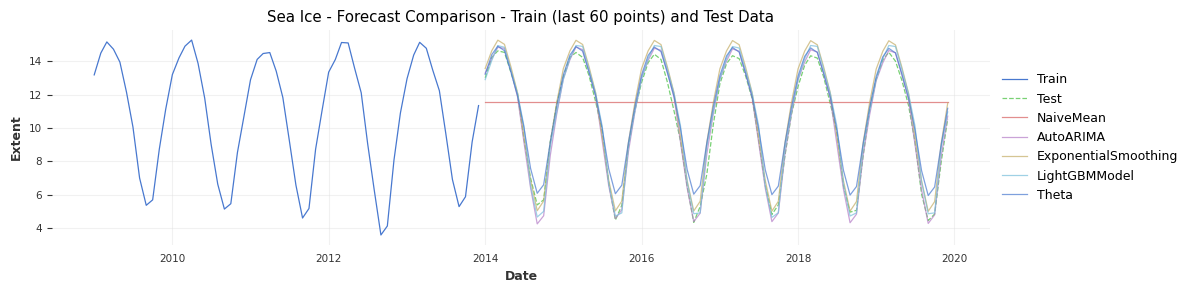

In [17]:
import warnings
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from minieda import summarize  # pip install git+https://github.com/dbolotov/minieda.git

from darts import TimeSeries
from darts.models import NaiveMean, AutoARIMA, ExponentialSmoothing, LightGBMModel, Theta
from darts.dataprocessing.transformers import Scaler
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.metrics import mae, rmse

from sklearn.linear_model import LinearRegression

# Suppress sklearn warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# Display and plot settings
pd.set_option("display.width", 220)
plt.rcParams.update({'font.size': 9})

# Load dataset and display first few rows
df = sns.load_dataset("seaice")

print("----- SCRIPT OUTPUT -----")
print("\n----- First Few Rows of Data -----\n")
print(df.head())

# Display summary
print("\n----- Data Summary -----\n")
print(summarize(df, include_perc=False, sort=True))

# Sort by date and set Date as index
df = df.sort_values("Date").set_index("Date")

# Resample to different frequency using linear interpolation
df_resampled = df.resample("MS").interpolate("linear") # monthly

# Drop any missing values (usually at the edges)
df_resampled = df_resampled.dropna()

# Convert to Darts TimeSeries, allowing it to infer frequency
dts = TimeSeries.from_series(df_resampled["Extent"], fill_missing_dates=True, freq=None)

# Show darts info
print("\n----- darts TimeSeries Summary -----\n")
print("frequency: ", dts.freq_str)

# Split the series into training and test sets
test_frac = 0.15
n_test = int(len(dts) * test_frac)
train, test = dts[:-n_test], dts[-n_test:]

# Confirm split sizes
print(f"Train range: {train.start_time().date()} to {train.end_time().date()} ({train.n_timesteps} steps)")
print(f"Test  range: {test.start_time().date()} to {test.end_time().date()} ({test.n_timesteps} steps)")

# Normalize
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Initialize models
models = {
    "NaiveMean": NaiveMean(),
    "AutoARIMA": AutoARIMA(season_length=12, max_p=2, max_q=2,
                            max_P=1, max_Q=1, max_d=1, max_D=1),
    "ExponentialSmoothing": ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.ADDITIVE,
                                                seasonal_periods=12,damped=True),
    "LightGBMModel": LightGBMModel(lags=12, output_chunk_length=1,
        random_state=42, verbose=-1, force_col_wise=True),
    "Theta": Theta(season_mode=SeasonalityMode.ADDITIVE),
}

# ---- TRAIN MODELS AND PREDICT ----

results = []
forecasts_test = {}

print("\n----- Training Models -----\n")

for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()

    # Use unscaled data for ARIMA and ExponentialSmoothing
    if name in ["AutoARIMA", "ExponentialSmoothing"]:
        model.fit(train)
        pred_test = model.predict(n=len(test))
    else:
        model.fit(train_scaled)
        pred_test_scaled = model.predict(n=len(test_scaled))
        pred_test = scaler.inverse_transform(pred_test_scaled)

    train_duration = time.time() - start_time
    forecasts_test[name] = pred_test

    # Evaluate on test set
    results.append({
        "Model": name,
        "MAE": mae(test, pred_test),
        "RMSE": rmse(test, pred_test),
        "Train Time (s)": train_duration
    })

print("\n----- EVALUATION -----\n")

# Display results
results_df = pd.DataFrame(results).sort_values("RMSE")
print(results_df.to_string(index=False))

# Plot: final 60 train + full test + predictions on test
train_to_plot = train[-60:]  # last 60 points from train

plt.figure(figsize=(12, 3))

# Plot actual data
train_to_plot.plot(label="Train", linewidth=0.9)
test.plot(label="Test", linewidth=0.9, alpha=0.9, linestyle="--")

# Plot forecasts made on test set
for name, forecast in forecasts_test.items():
    if forecast is not None:
        forecast.plot(label=name, linewidth=0.9, alpha=0.7)

plt.title("Sea Ice - Forecast Comparison - Train (last 60 points) and Test Data")
plt.xlabel("Date")
plt.ylabel("Extent")
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()